In [43]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

# Llamamos las bibliotecas para analizar las Series de Tiempo y Modelos de Pronóstico
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Sumprimimos los mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Paso 1. Construcción de una Serie de Tiempo

In [44]:
# Tomar la dirección URL del archivo en formato 'raw'
url = 'https://raw.githubusercontent.com/Eduardo-Lares-Miranda/FisicaComputacional1/master/Evaluaci%C3%B3n%201/co2_brw_DailyData.txt'

In [47]:
# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 151 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','Concentracion CO2','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag']
df_alaska = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_eua = df_alaska.copy()

# Reemplazamos los textos '-999.99' por 'NaN'
str_Nulo = -999.99
df_eua1 = df_eua.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','Concentracion CO2','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag']
for cols in cols_list:
   df_eua1[cols] = pd.to_numeric(df_eua1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_eua2_ts = df_eua1.copy()

#Con estas filas cree la nueva columna fecha uniendo el año, mes y día.
df_eua2_ts['Fecha'] = pd.to_datetime(df_eua2_ts[['Año','Mes','Dia']]
                   .astype(str).apply(' '.join, 1), format='%Y %m %d')

df_eua2_ts['Fecha'] = (pd.to_datetime(df_eua2_ts['Año'].astype(str) + '-' +
                                  df_eua2_ts['Mes'].astype(str) + '-' +
                                  df_eua2_ts['Dia'].astype(str)))

In [48]:
# Definimos un nuevo DataFrame para el análisis de los datos. 
# Será nuestro nuevo punto de partida.
df_datos_ts = df_eua2_ts.copy()
print(df_datos_ts.head())
print(df_datos_ts.tail())

   site_code   Año  Mes  Dia  ...  Elevacion  intake_height  qcflag      Fecha
0        NaN  1973    1    2  ...       11.0           16.0     NaN 1973-01-02
1        NaN  1973    1    3  ...       11.0           16.0     NaN 1973-01-03
2        NaN  1973    1    4  ...       11.0           16.0     NaN 1973-01-04
3        NaN  1973    1    5  ...       11.0           16.0     NaN 1973-01-05
4        NaN  1973    1    6  ...       11.0           16.0     NaN 1973-01-06

[5 rows x 18 columns]
       site_code   Año  Mes  Dia  ...  Elevacion  intake_height  qcflag      Fecha
17159        NaN  2019   12   26  ...       11.0          16.46     NaN 2019-12-26
17160        NaN  2019   12   27  ...       11.0          16.46     NaN 2019-12-27
17161        NaN  2019   12   28  ...       11.0          16.46     NaN 2019-12-28
17162        NaN  2019   12   29  ...       11.0          16.46     NaN 2019-12-29
17163        NaN  2019   12   30  ...       11.0          16.46     NaN 2019-12-30

[5 r

Creamos una serie de tiempo desde el inicio de 1980 hasta fin de 2019, fijando la variable 'Fecha' como nuevo índice del DataFrame.

In [49]:
df_datos_ts = df_datos_ts.set_index('Fecha')
# Vamos a utilizar los últimos de datos, que corresponden al periodo 1980-2019
df_80_ts = df_datos_ts[(df_datos_ts['Año'] >= 1980) & (df_datos_ts['Año'] < 2020)]
df_80_ts.head()

,site_code,Año,Mes,Dia,Hora,Minuto,Segundo,time_decimal,Concentracion CO2,value_std_dev,nvalue,Latitud,Longitud,Altitud,Elevacion,intake_height,qcflag
Fecha,,,,,,,,,,,,,,,,,
1980-01-01,NaN,1980,1,1,0,0,0,1980.000000,341.38,0.08,2,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-02,NaN,1980,1,2,0,0,0,1980.002732,341.65,0.21,21,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-03,NaN,1980,1,3,0,0,0,1980.005464,NaN,-99.99,0,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-04,NaN,1980,1,4,0,0,0,1980.008197,NaN,-99.99,0,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-05,NaN,1980,1,5,0,0,0,1980.010929,NaN,-99.99,0,71.323,-156.611,27.46,11.0,16.46,NaN


La serie de tiempo de concentraciones de CO2 sólo deberá tener la Fecha como índice y la columna de CO2.

In [50]:
df_80co2_ts = df_80_ts.drop(['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag'], axis=1)
df_80co2_ts.head(10)

,Concentracion CO2
Fecha,
1980-01-01,341.38
1980-01-02,341.65
1980-01-03,NaN
1980-01-04,NaN
1980-01-05,NaN
1980-01-06,342.32
1980-01-07,342.48
1980-01-08,NaN
1980-01-09,NaN


Usamos ts_test.ffill(axis = 0, inplace=True), para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible.

In [52]:
df_80co2_ts.ffill(axis = 0, inplace=True)

#Paso 2. Análisis de la Serie de Tiempo

Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller. test_stationarity(df_s)

In [53]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desvación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.

In [54]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1980 a 2019
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2019-12'
ts_80 = df_80co2_ts.loc[start:end].copy()
ts_80.head()

,Concentracion CO2
Fecha,
1980-01-01,341.38
1980-01-02,341.65
1980-01-03,341.65
1980-01-04,341.65
1980-01-05,341.65


In [55]:
# Vemos su encabezado
ts_80['Concentracion CO2'].head()

Fecha
1980-01-01    341.38
1980-01-02    341.65
1980-01-03    341.65
1980-01-04    341.65
1980-01-05    341.65
Name: Concentracion CO2, dtype: float64

In [57]:
# Definimos la Serie de Tiempo con Concentracion de CO2 que vamos a estudiar, le damos un nombre genérico

ts_test = ts_80['Concentracion CO2'].copy()

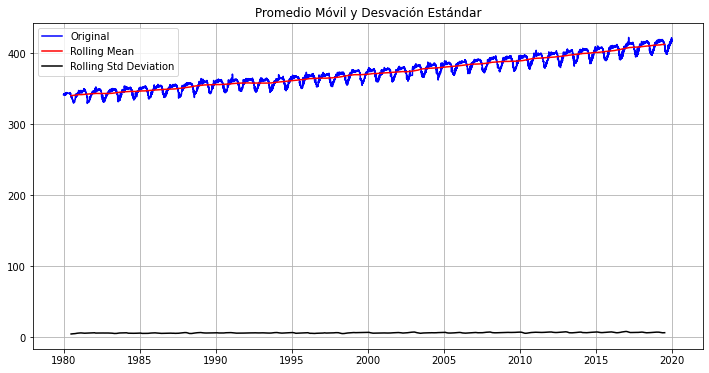

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -3.236940
p-value                            0.017944
#Lags Used                        37.000000
Number of Observations Used    14571.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [58]:
# Realizamos la Prueba de Estacionalidad de la Concentración de CO2
test_stationarity(ts_test)

Notamos que p es p>0.05 (0.017944) por lo que es estacionaria.

Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto).

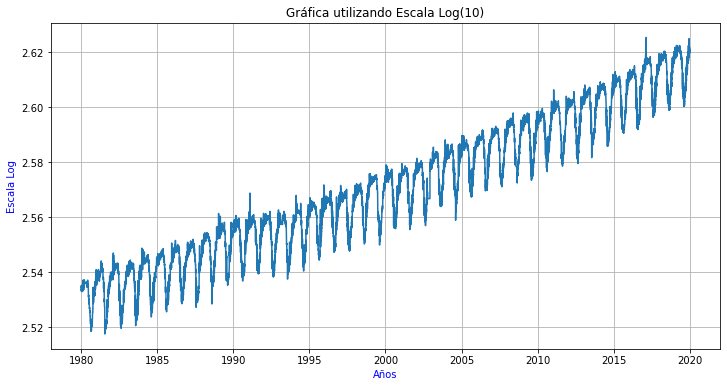

In [60]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

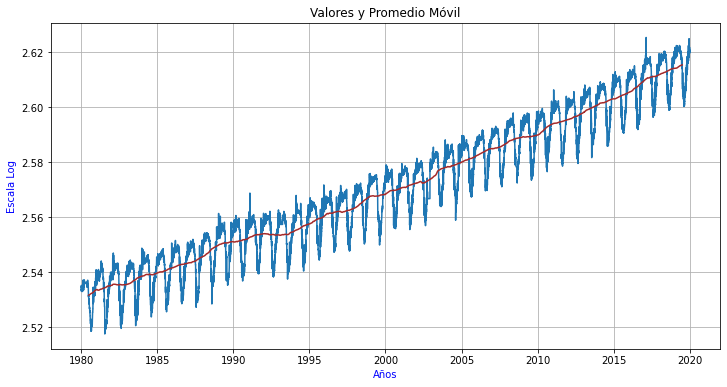

In [61]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [63]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion CO2, dtype: float64

In [66]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01   -0.000151
1980-07-02    0.000048
1980-07-03   -0.001153
1980-07-04   -0.001152
1980-07-05   -0.001164
Name: Concentracion CO2, dtype: float64

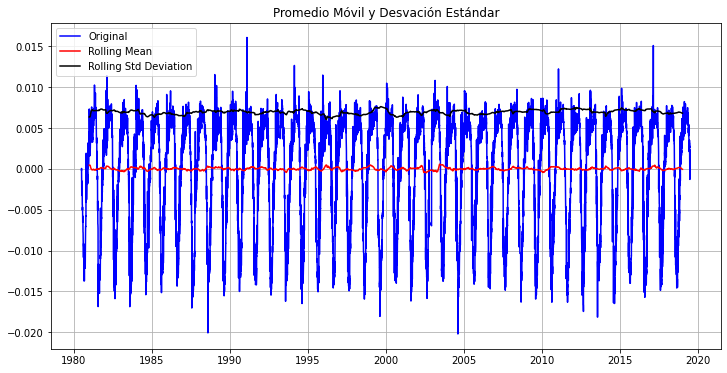

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.483177e+01
p-value                        1.894479e-27
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [68]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

El valor de p<0.05 (3.766921e-26), por lo que la serie estacionaria.

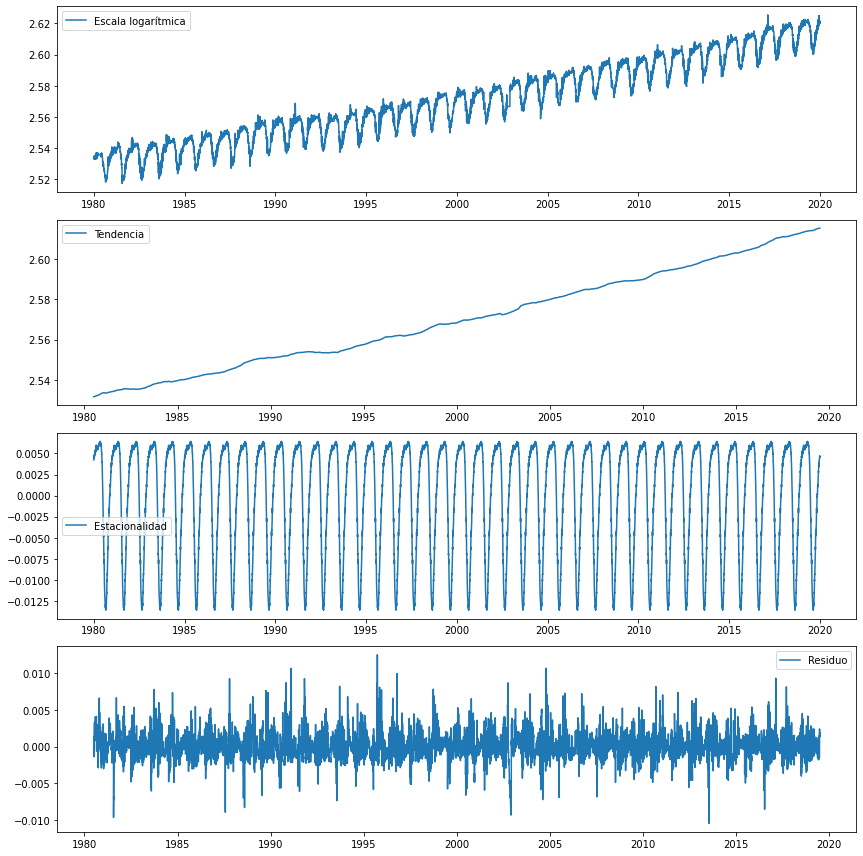

In [69]:
# Método de descomposición usando statsmodels.tsa

descomposicion_estacional = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# 3 componentes: tendencia, estacionalidad, residuo

Tendencia = descomposicion_estacional.trend
Estacionalidad = descomposicion_estacional.seasonal
Residuo = descomposicion_estacional.resid

# Gráficas de componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Escala logarítmica')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(Tendencia, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(Estacionalidad, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(Residuo, label='Residuo')
plt.legend(loc='best')

# Esto es para disminuir espacio entre gráficos
plt.tight_layout();


Se puede ver que el aumento de CO2 es mayor con el pasar de los años y su acumulación depende la estación del año.

Prueba la estacionaridad de la serie residuo.

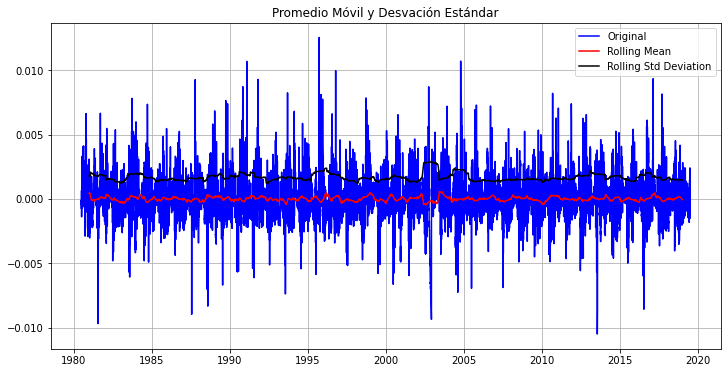

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -22.745264
p-value                            0.000000
#Lags Used                        12.000000
Number of Observations Used    14232.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [70]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = Residuo 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

Al ser p=0 tenemos toda la certeza de que es estacionaria.

Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastarlo en una gráfica con la serie de Log CO2.

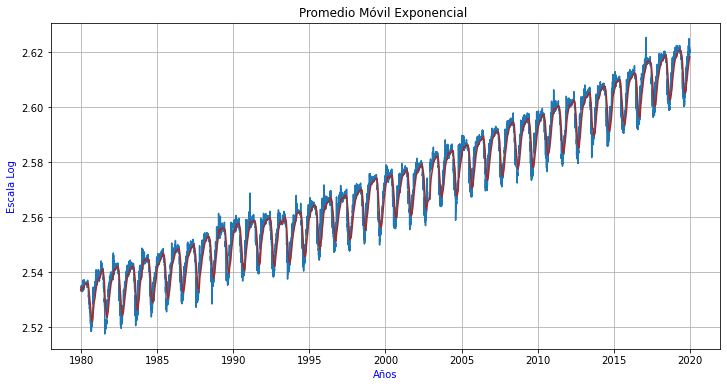

In [71]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=20).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.

In [72]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion CO2, dtype: float64

In [73]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01   -0.000151
1980-07-02    0.000048
1980-07-03   -0.001153
1980-07-04   -0.001152
1980-07-05   -0.001164
Name: Concentracion CO2, dtype: float64

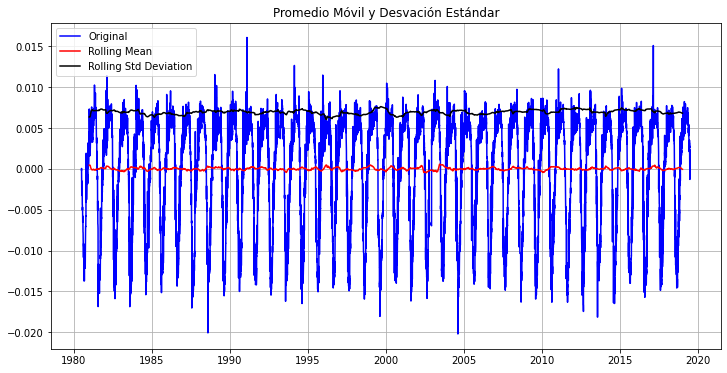

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.483177e+01
p-value                        1.894479e-27
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [74]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

Al ser un valor del orden e-27 podemos decir que es estacionaria.

Adicionalmente, prueva construir una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil.

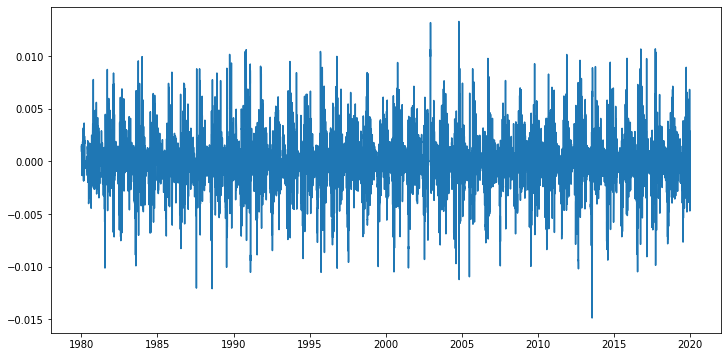

In [75]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.

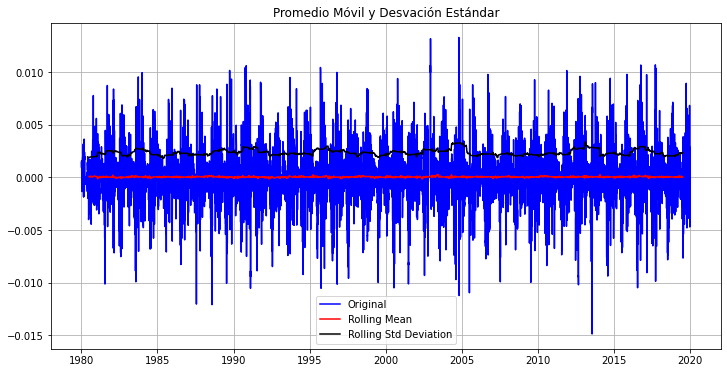

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.141389e+01
p-value                        7.139830e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [76]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

Al ser p con un orden de e-21 podemos decir que es estacionaria.

In [77]:
# Número de datos utilizados
len(ts_test_log_diff)

14602

Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos drivado una vez).

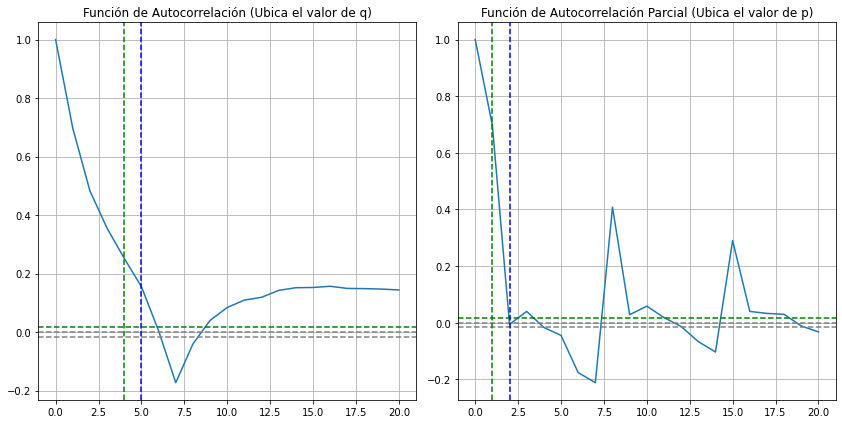

In [78]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.axvline(x=5, linestyle='--', color='blue')
plt.grid()
plt.title('Función de Autocorrelación (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=1, linestyle='--', color='green')
plt.axvline(x=2, linestyle='--', color='blue')
plt.grid()
plt.title('Función de Autocorrelación Parcial (Ubica el valor de p)')

plt.tight_layout()

Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q) y ARIMA (p, d, q).

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARIMA Model Results                              
Dep. Variable:     D.Concentracion CO2   No. Observations:                14608
Model:                  ARIMA(2, 1, 0)   Log Likelihood               76726.319
Method:                        css-mle   S.D. of innovations              0.001
Date:                 Thu, 25 Feb 2021   AIC                        -153444.637
Time:                         06:08:57   BIC                        -153414.280
Sample:                     01-02-1980   HQIC                       -153434.552
                          - 12-30-2019                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      5.975e-06    7.8e-06      0.766      0.444   -9.32e-06    2.13e-05
ar.L1.D.Concentracion CO2    -0.1744      0.008    -21.386      0.000      -0.

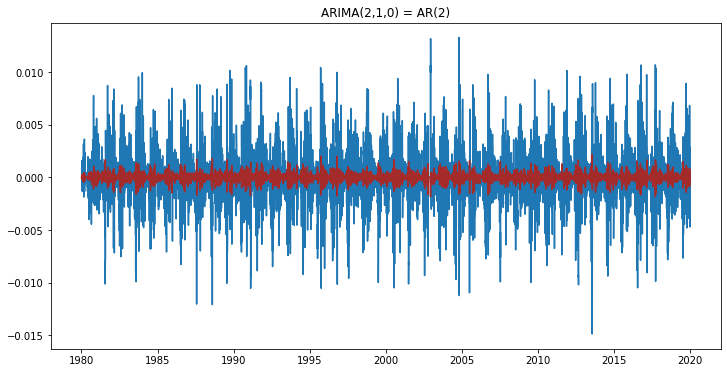

In [79]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARIMA Model Results                              
Dep. Variable:     D.Concentracion CO2   No. Observations:                14608
Model:                  ARIMA(0, 1, 4)   Log Likelihood               76857.128
Method:                        css-mle   S.D. of innovations              0.001
Date:                 Thu, 25 Feb 2021   AIC                        -153702.256
Time:                         06:09:20   BIC                        -153656.720
Sample:                     01-02-1980   HQIC                       -153687.128
                          - 12-30-2019                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       5.96e-06   5.86e-06      1.017      0.309   -5.52e-06    1.74e-05
ma.L1.D.Concentracion CO2    -0.2046      0.008    -24.706      0.000      -0.

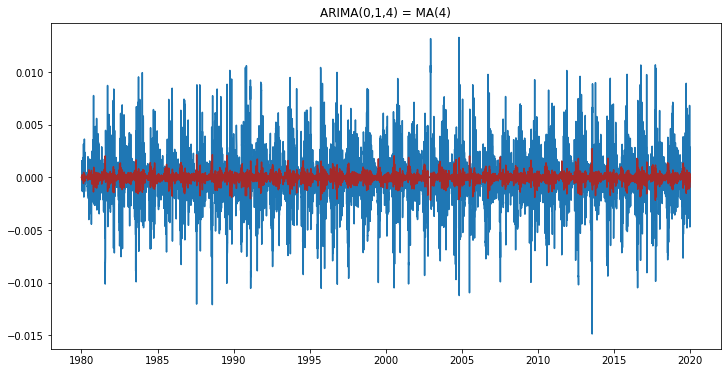

In [80]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                              ARIMA Model Results                              
Dep. Variable:     D.Concentracion CO2   No. Observations:                14608
Model:                  ARIMA(2, 1, 4)   Log Likelihood               76857.118
Method:                        css-mle   S.D. of innovations              0.001
Date:                 Thu, 25 Feb 2021   AIC                        -153698.235
Time:                         06:10:06   BIC                        -153637.521
Sample:                     01-02-1980   HQIC                       -153678.065
                          - 12-30-2019                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      5.958e-06   5.88e-06      1.013      0.311   -5.57e-06    1.75e-05
ar.L1.D.Concentracion CO2     0.2258        nan        nan        nan         

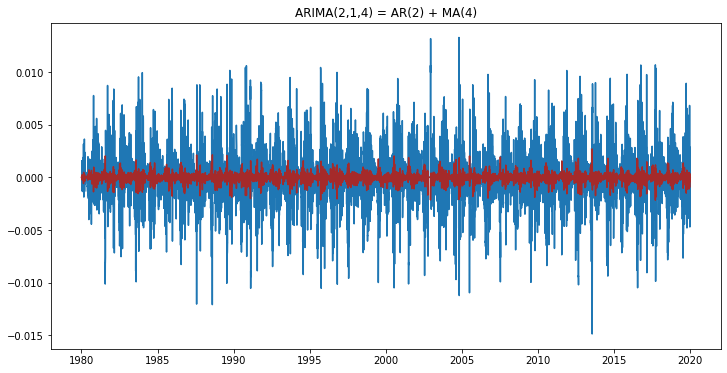

In [81]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Basando en el AIC, el que muestra el valor mínimo es el modelo ARIMA, por lo cual es mejor.

Contrasta la serie observada de concentraciones de CO2 ontra la construida por el modelo ARIMA.

In [82]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000006
1980-01-03   -0.000044
1980-01-04   -0.000050
1980-01-05   -0.000025
1980-01-06   -0.000014
                ...   
2019-12-26   -0.000392
2019-12-27   -0.000051
2019-12-28    0.000145
2019-12-29    0.000090
2019-12-30    0.000041
Length: 14608, dtype: float64


In [83]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.533587
1980-01-03    2.533537
1980-01-04    2.533531
1980-01-05    2.533556
dtype: float64
Fecha
2019-12-26    2.619723
2019-12-27    2.619939
2019-12-28    2.620104
2019-12-29    2.620237
2019-12-30    2.620854
dtype: float64


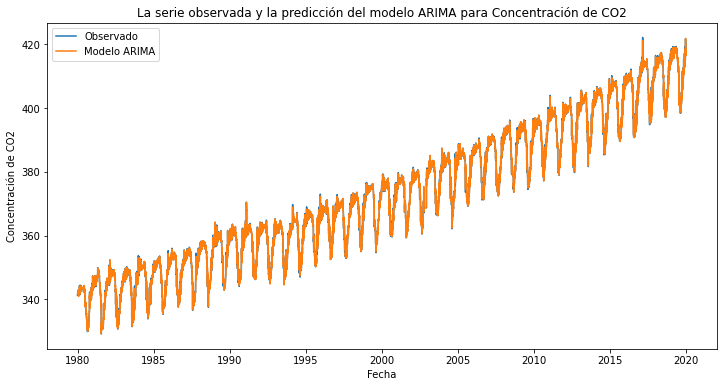

In [84]:
# Regresamos a la escala original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para Concentración de CO2')
plt.legend(loc='best');

Calcula el error RMSE.

In [85]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.2879856147482848


Por último contrasta los últimos 5 años de la Serie de CO2 y el modelo ARIMA para ver mas a detalle el modelo.

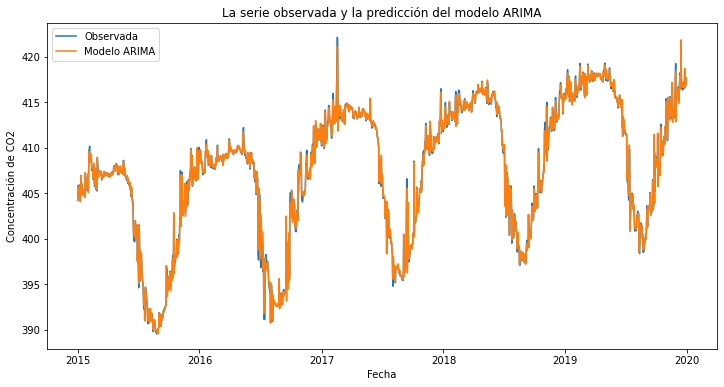

In [86]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');